Use Google colab for TPU

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
trainX = np.load("/content/drive/MyDrive/archive/trainandtest/trainX.npy").astype(np.float32)
trainY = np.load("/content/drive/MyDrive/archive/trainandtest/trainY.npy").astype(np.float32)
testX = np.load("/content/drive/MyDrive/archive/trainandtest/testX.npy").astype(np.float32)
testY = np.load("/content/drive/MyDrive/archive/trainandtest/testY.npy").astype(np.float32)

In [ ]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [ ]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


In [ ]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (120, 512, 512, 1)
trainY: (120, 512, 512, 1)
testX: (31, 512, 512, 1)
testY: (31, 512, 512, 1)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# modified unet -- for better accuracy

def modified_unet(input_size=(512, 512, 1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    # Encoder with BatchNormalization and Dropout
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck with Dropout
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder with Transposed Convolutions
    up6 = concatenate([
        Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop5), drop4
    ], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([
        Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv6), drop3
    ], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([
        Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv7), drop2
    ], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([
        Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv8), drop1
    ], axis=-1)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output layer
    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### Modified U-Net Architecture with BatchNormalization and Dropout

modified version of the U-Net model for image segmentation tasks. It includes enhancements such as **BatchNormalization** and **Dropout** layers, which help improve the training stability and generalization ability of the model.

Key Features:
- **Encoder:** Convolutional layers followed by **BatchNormalization** and **Dropout** to improve model robustness and prevent overfitting.
  - The encoder progressively extracts features with increasing filter sizes and pooling layers.
- **Bottleneck:** The middle layer, with the most filters, learns abstract representations.
- **Decoder:** Uses **Transpose Convolutions** (up-sampling) to recover spatial dimensions, followed by convolutional layers and **BatchNormalization** for finer feature extraction.
- **Skip Connections:** These connections concatenate corresponding encoder and decoder layers to retain high-resolution details, critical for precise segmentation.
- **Dropout:** Applied in various layers to prevent overfitting during training.

This version of U-Net is designed to be more robust by regularizing the model with **BatchNormalization** and **Dropout**, which can be particularly helpful for complex segmentation tasks like medical image analysis.

In [ ]:
# normal unet
""" def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)

    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

    """

### U-Net Architecture Implementation

U-Net model for image segmentation tasks, commonly used in medical image analysis. The model consists of an encoder-decoder architecture with a bottleneck, designed to segment images (e.g., CT scans or medical imaging data) into meaningful regions.

Key Features:
- **Encoder:** Successive convolutional layers with increasing filter sizes and max pooling layers to down-sample the input.
- **Bottleneck:** A layer with the largest number of filters to learn abstract representations.
- **Decoder:** Uses transpose convolutions (up-sampling) to recover spatial dimensions, followed by convolutional layers to refine the segmentation.
- **Skip Connections:** Concatenate feature maps from the encoder with corresponding feature maps in the decoder to preserve high-resolution details.

The model outputs a binary mask (segmented area) using a sigmoid activation function.

This model can be used for segmentation tasks where pixel-level accuracy is essential, such as tumor detection or organ segmentation in medical images.

In [ ]:
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
weight_path="checkpoint-{epoch:03d}-{val_dice_coef:.3f}.hdf5" # Callbacks for U-Net Training

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True) # ModelCheckpoint to save the best model based on validation loss

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6) # Reduce learning rate when validation loss plateaus
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=30) # Early stopping if validation loss doesn't improve for 30 epochs

CALLBACKS = [checkpoint, early, reduceLROnPlat] # Combine all callbacks

In [ ]:
with strategy.scope():
  model = unet(input_size=(512,512,1))
  model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics = [dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 32,
                    epochs = 250,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/250
4/4 [==============================] - ETA: 0s - loss: -0.0015 - dice_coef: 0.0015 - binary_accuracy: 0.2385
Epoch 1: val_loss improved from inf to -0.00175, saving model to checkpoint-001-0.002.hdf5
4/4 [==============================] - 77s 13s/step - loss: -0.0015 - dice_coef: 0.0015 - binary_accuracy: 0.2385 - val_loss: -0.0018 - val_dice_coef: 0.0018 - val_binary_accuracy: 0.9865 - lr: 2.0000e-04
Epoch 2/250
4/4 [==============================] - ETA: 0s - loss: -0.0015 - dice_coef: 0.0015 - binary_accuracy: 0.9921
Epoch 2: val_loss improved from -0.00175 to -0.00179, saving model to checkpoint-002-0.002.hdf5
4/4 [==============================] - 2s 497ms/step - loss: -0.0015 - dice_coef: 0.0015 - binary_accuracy: 0.9921 - val_loss: -0.0018 - val_dice_coef: 0.0018 - val_binary_accuracy: 0.9956 - lr: 2.0000e-04
Epoch 3/250
4/4 [==============================] - ETA: 0s - loss: -0.0016 - dice_coef: 0.0015 - binary_accuracy: 0.9955
Epoch 3: val_loss improved from -0.0017

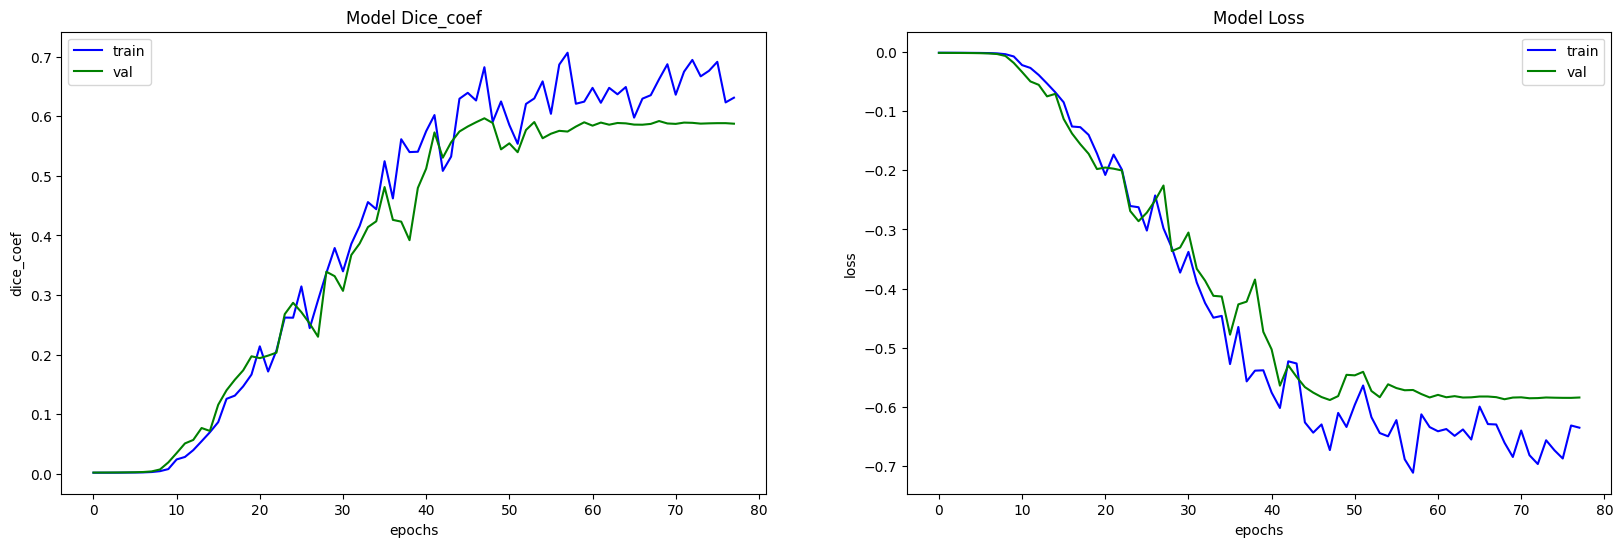

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:

import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history


In [ ]:
model.save("LC_v4_UNet_cl.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(testX, testY)

1/1 [==============================] - 1s 633ms/step - loss: -0.5840 - dice_coef: 0.5876 - binary_accuracy: 0.9996


[-0.5839937329292297, 0.5876282453536987, 0.999613344669342]

In [ ]:
with strategy.scope():
  model2 = unet(input_size=(512,512,1))
  model2.load_weights("/content/checkpoint-048-0.597.hdf5")

  model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

model2.evaluate(testX, testY)

1/1 [==============================] - 18s 18s/step - loss: -0.5882 - dice_coef: 0.5967 - binary_accuracy: 0.9996


[-0.588224470615387, 0.5966993570327759, 0.9996433854103088]

In [ ]:
model2.save("LC_v4_UNet_best_Model_checkpoint_cl.h5")

1/1 [==============================] - 0s 455ms/step


IndexError: index 31 is out of bounds for axis 0 with size 31

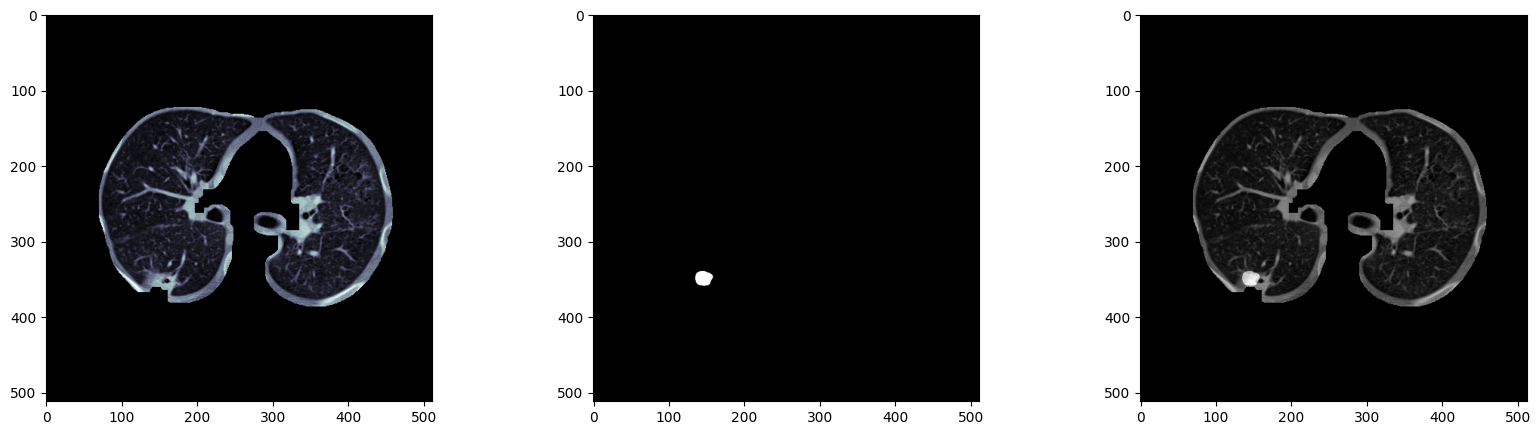

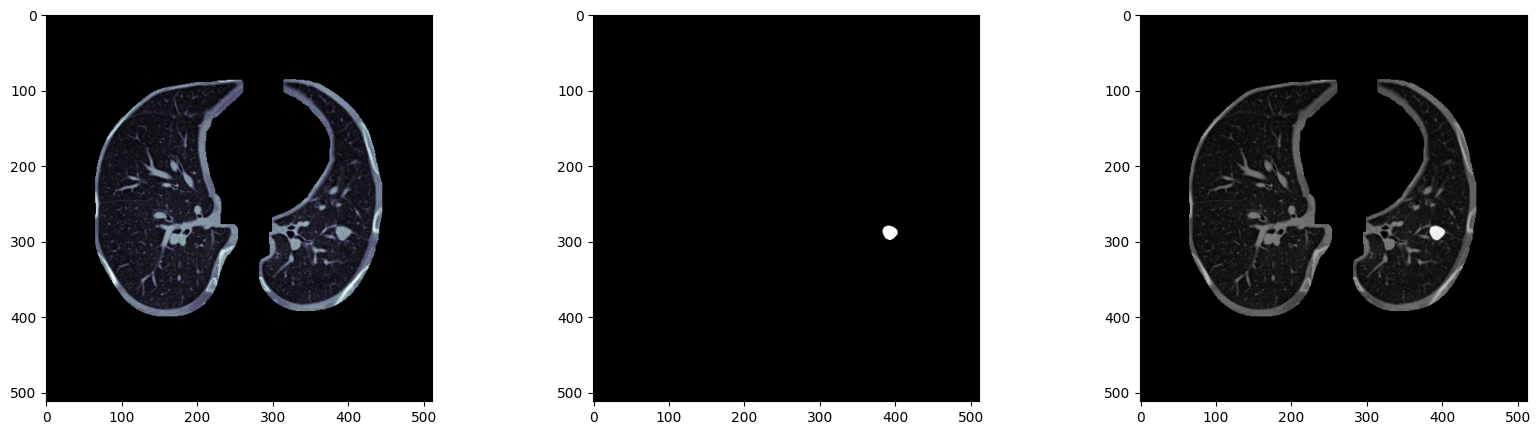

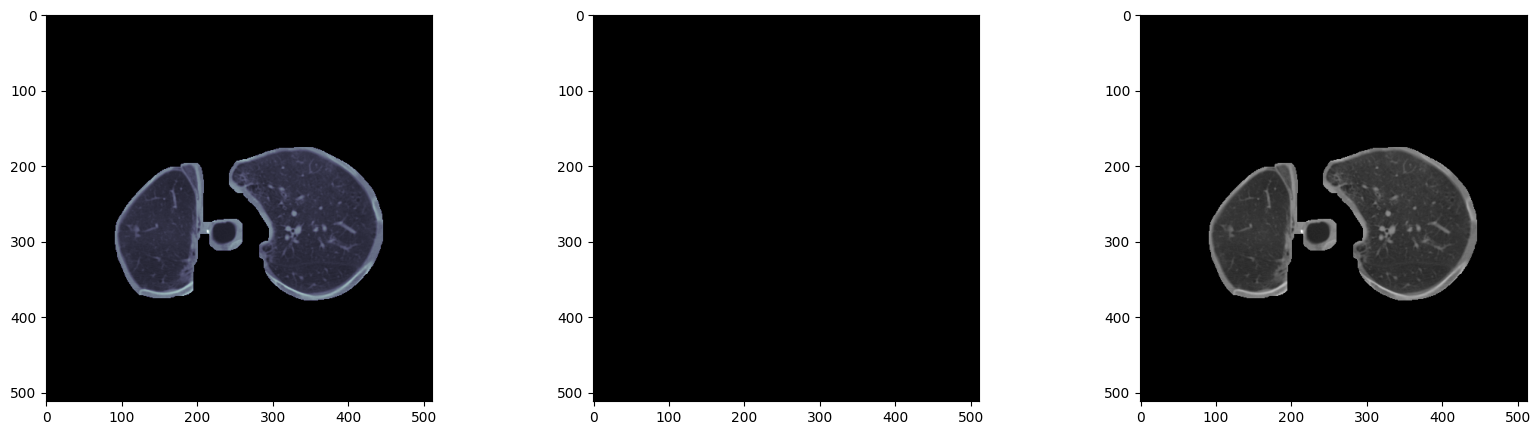

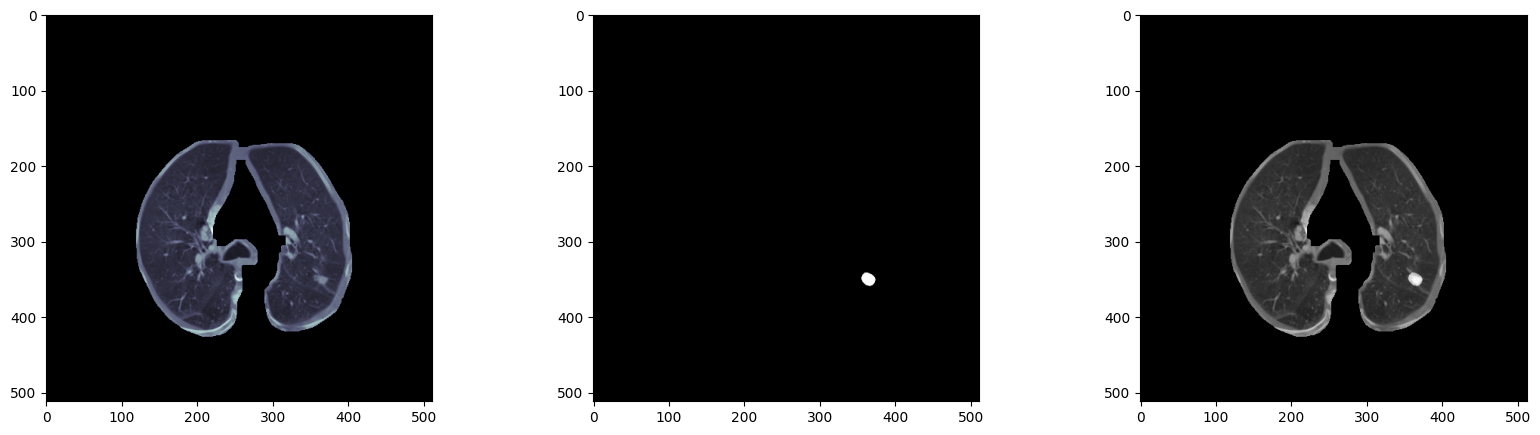

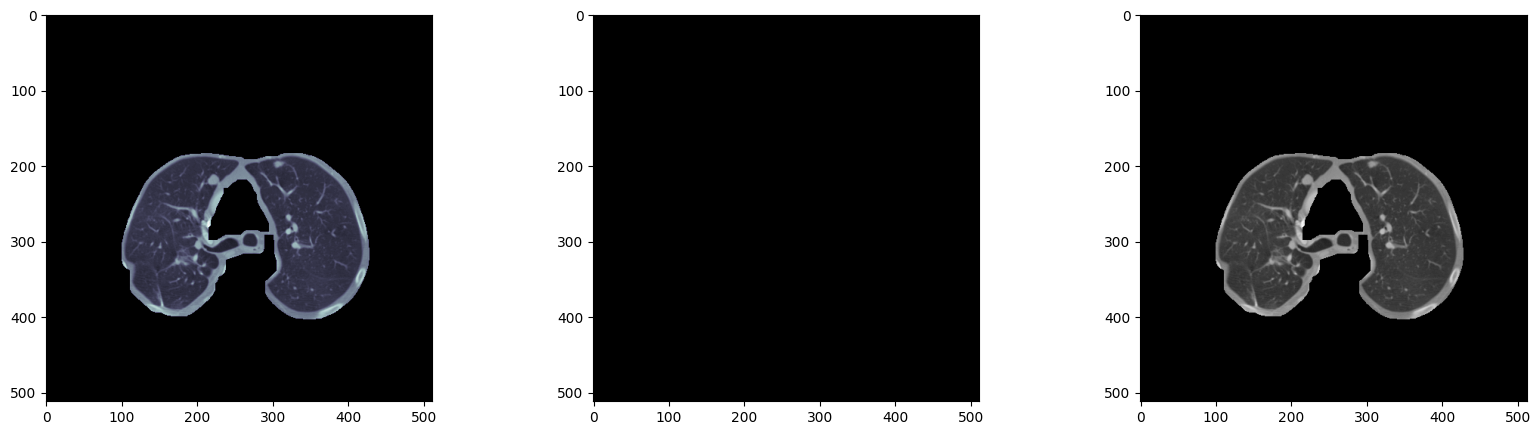

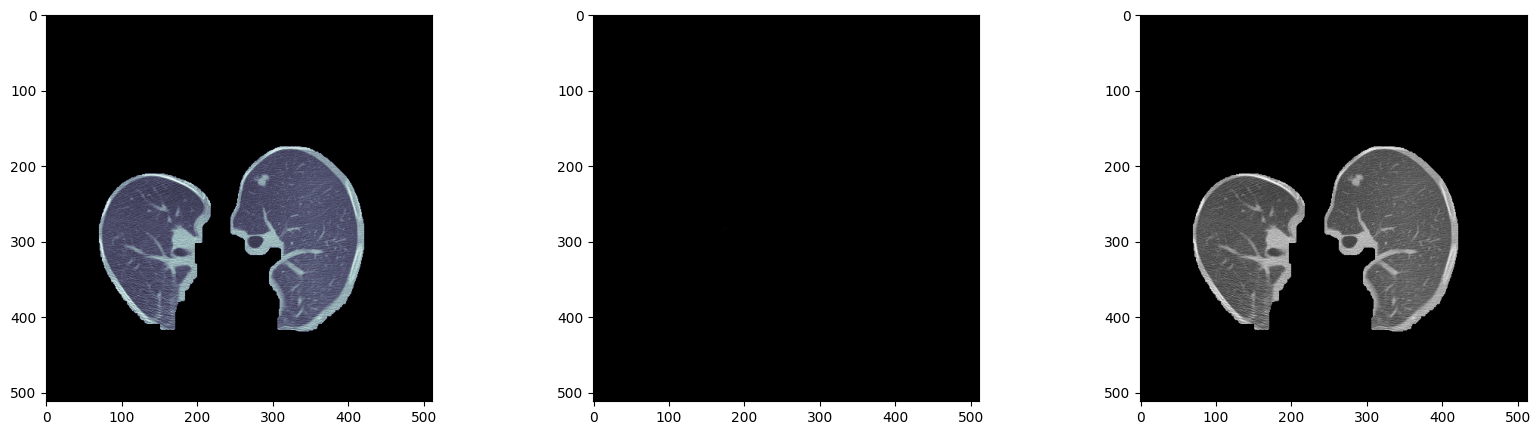

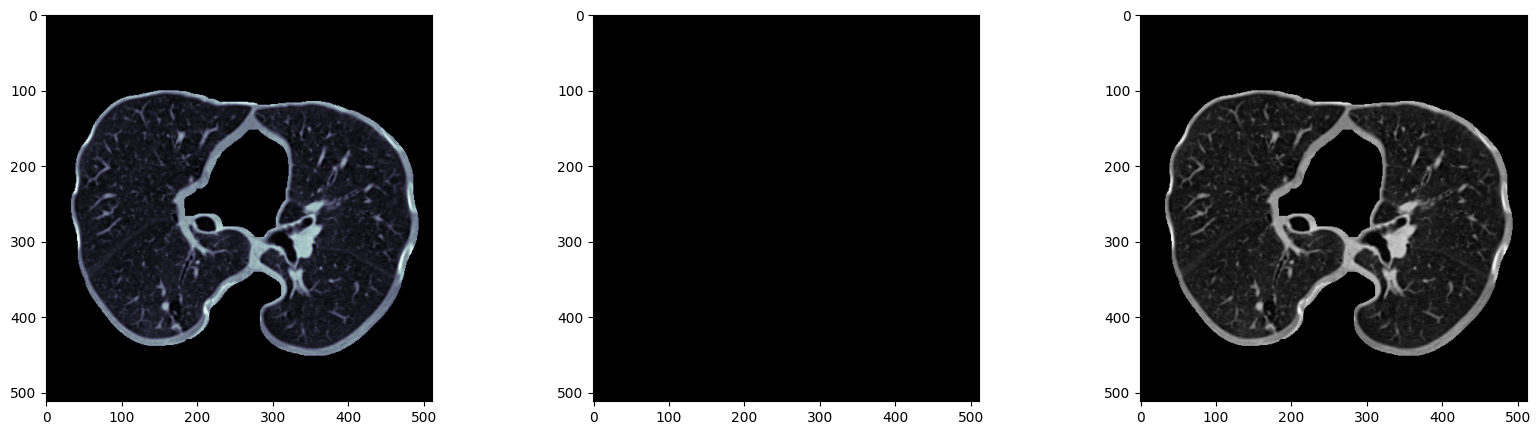

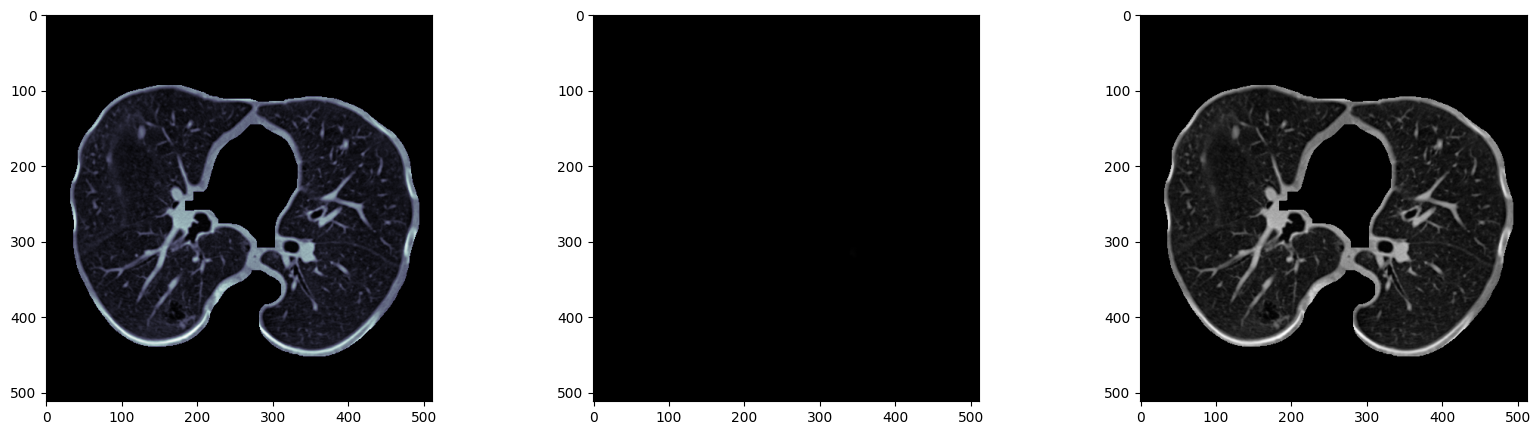

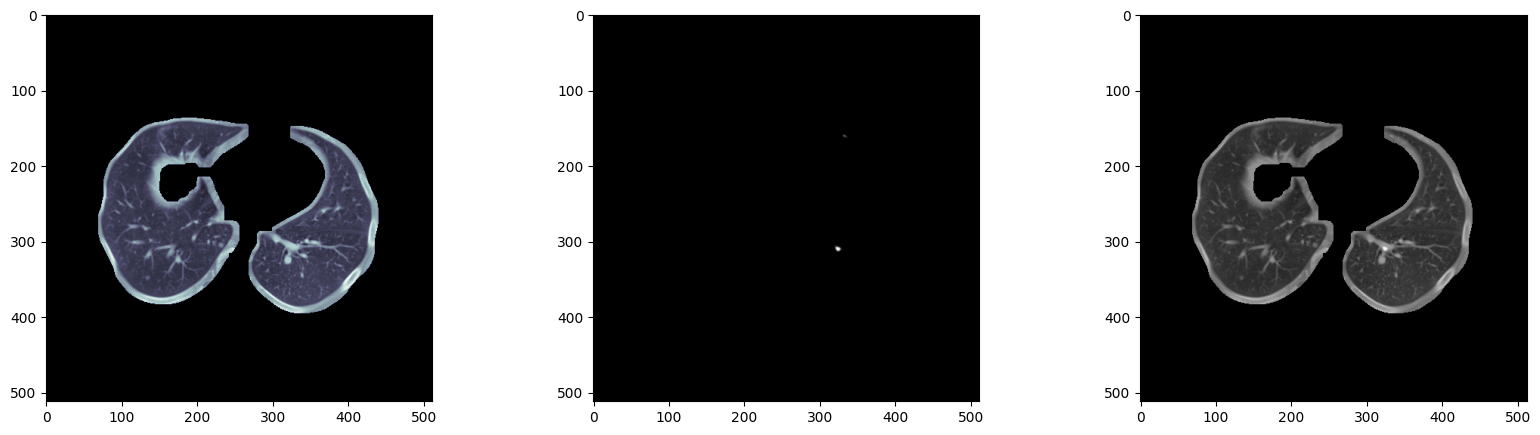

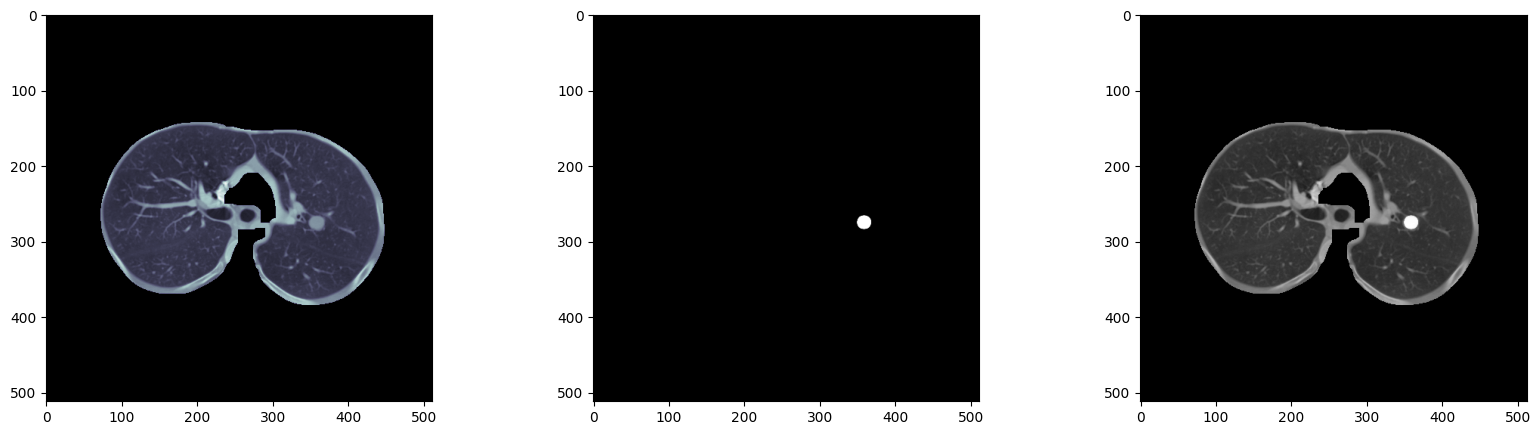

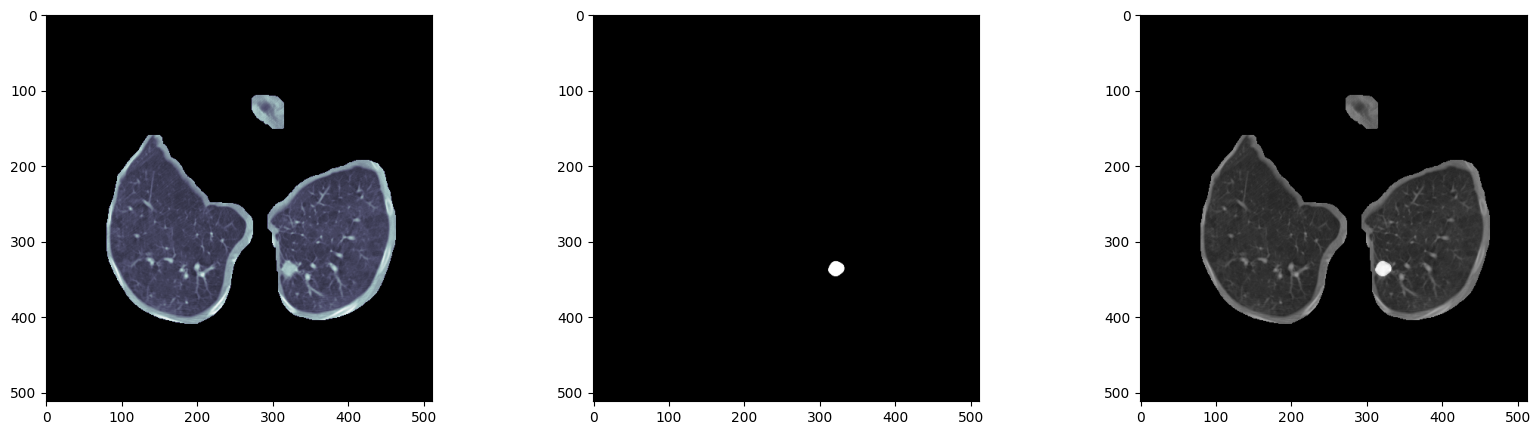

In [ ]:
j = 1
for i in range(20,80):
  test = np.squeeze(testX)[i]
  t_p = model2.predict(np.reshape(test, (1,512,512,1)))

  plt.figure(figsize=(20,300))
  plt.subplot(50,3,j)
  plt.imshow(np.squeeze(test), cmap="bone")
  plt.subplot(50,3,j+1)
  plt.imshow(np.squeeze(t_p), cmap="gray")
  plt.subplot(50,3,j+2)
  plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
  j += 3

In [ ]:
!cp LC_v4_UNet_cl.h5 /content/drive/MyDrive/archive/processed/LC_v4_UNet_cl.h5
!cp LC_UNet_trainHistory /content/drive/MyDrive/archive/processed/LC_UNet_trainHistory

In [ ]:
!cp LC_v4_UNet_best_Model_checkpoint_cl.h5 /content/drive/MyDrive/archive/processed/LC_UNet_best_Model_checkpoint.h5